In [124]:
# importing cell
import numpy as np
import numpy.random as npr
npr.seed(5555)
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from sklearn import manifold
from time import time
from collections import OrderedDict
from sklearn.cluster import DBSCAN

# LCPB 21-22 Exercise 4, data visualization and clustering

## Exercise 4A

Consider data generated during the lesson.



In [125]:
x = np.loadtxt('DATA/x_3d.dat') # shaped like (1000,3) 
y = np.loadtxt('DATA/y_3d.dat') # shaped like (1000,)

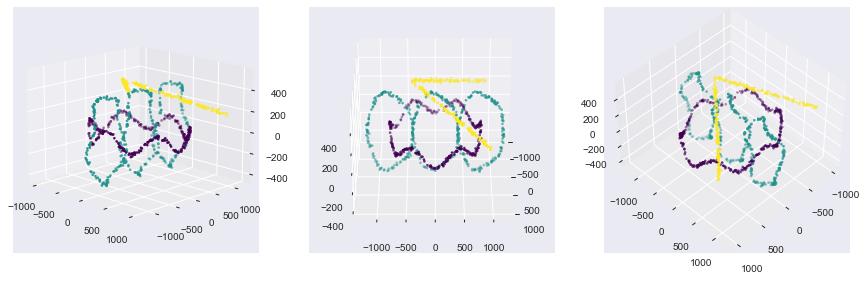

In [126]:
fig = plt.figure(figsize=(15, 5))
for i in range(3):
    ax = fig.add_subplot(1,3,i+1,projection='3d')
    ax.scatter(x[:,0], x[:,1],x[:,2], s=5, c=y, depthshade=True, cmap='viridis')
    ax.view_init(15+15*i, 45*(i-1))
plt.draw()

### 1) The role of dimensions

In each sample increase the number of dimensions from 3 to L>3, by introducing L-3
additional dimensions with noisy inputs. Study how visualization with t-SNE and clustering
with DBSCAN are affected by this increase in dimensionality.
To mix the information between all L dimensions while preserving the distances between
points, one can also perform some rotation of data with orthonormal random matrices M in
O(L): x → M.x

In [127]:
# dimension increasing

N = x.shape[0]
L = 6
noise_scale = 25

x_aug = np.hstack((x,npr.normal(loc=0,scale=noise_scale,size=(N,L-3))))

from scipy.stats import special_ortho_group
Mrot = special_ortho_group.rvs(L) # routine from scipy that generates a random orthogonal matrix with det=1 in L dimensions
print(Mrot.shape)
print("Determinant: ",np.linalg.det(Mrot))


(6, 6)
Determinant:  1.0000000000000009


In [128]:
# apply the rotation
x_aug = (Mrot @ x_aug.T).T

#### t-SNE
We will now apply t-SNE to the augmented and rotated dataset, trying to get back to the original 3 dimensions.

In [129]:
n_components = 3
perplexity = 30 
tsne=manifold.TSNE(n_components=n_components,perplexity=perplexity,early_exaggeration=12.0,learning_rate=200.0)

x_tsne=tsne.fit_transform(x_aug)

/Users/raffaelegaudio/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


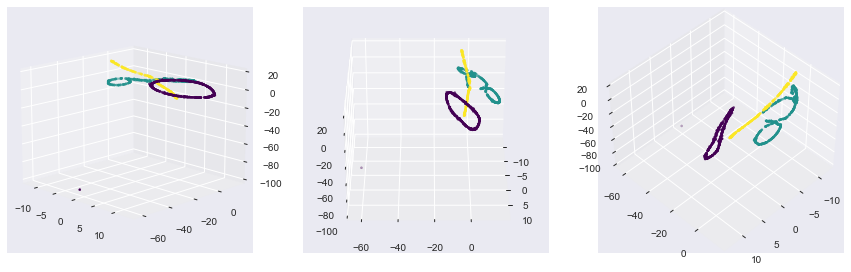

In [130]:
fig = plt.figure(figsize=(15, 5))
for i in range(3):
    ax = fig.add_subplot(1,3,i+1,projection='3d')
    ax.scatter(x_tsne[:,0], x_tsne[:,1],x_tsne[:,2], s=5, c=y, depthshade=True, cmap='viridis')
    ax.view_init(15+15*i, 45*(i-1))
plt.draw()

#### Comments on the performance of t-SNE over our dataset

Even when augmentating the dataset with 3 additional dimensions composed of gaussian noise and rotating it in the $L$-dimensional space, t-SNE manages to retrieve partial information about the original underlying structure of the dataset: points that were grouped together in a circle-like structure retain such structure although simplified (apparently the wavey component of it contributes the same to the entropy as a simpler one); points that were distributed along some sort of snapped line still present such structure with a breaking angle in the middle, and the more complicated rings pattern almost makes it back as a whole.


### 2) The role of “perplexity” in t-SNE

Provide your explanation on the patterns observed by varying the perplexity of t-SNE.
Do they vary if t-SNE is initialized by using principal component analysis (init=’pca’)?


/Users/raffaelegaudio/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/raffaelegaudio/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/raffaelegaudio/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/raffaelegaudio/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/raffaelegaudio/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


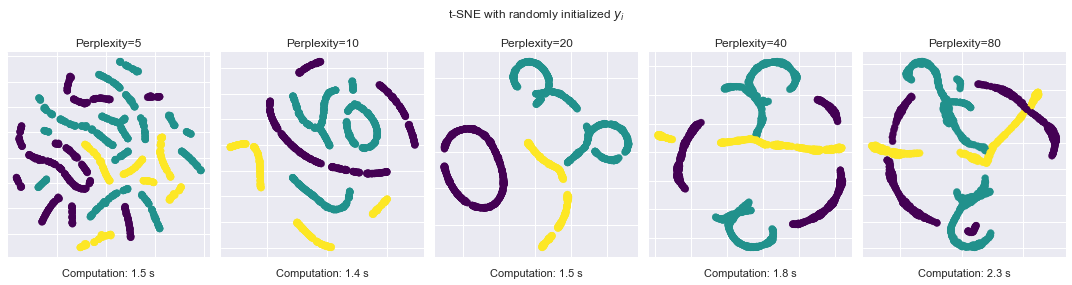

In [131]:
n_components = 2 
perplexities = [5, 10, 20, 40, 80]

(fig, subplots) = plt.subplots(1,len(perplexities) , figsize=(3*len(perplexities), 4))
fig.suptitle("t-SNE with randomly initialized $y_i$")
X_all = [None]
for i, perplexity in enumerate(perplexities):
    ax = subplots[i]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(x)
    t1 = time()
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=y,cmap='viridis')
    ax.tick_params(left=False,bottom=False)
    ax.set_xlabel("Computation: {:.2} s".format(t1-t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    X_all.append(Y)

fig.tight_layout()
plt.show()

#### Perplexity role

As discussed during lesson, the perplexity parameter determines, loosely speaking, the concept of distance between points; more precisely, it fixes the "local entropy" of the neighbours distribution for each data point. Lower values means a smaller $\sigma_i$ and thus the distribution is more "concentrated" and the algorithm, while trying to arrange the data according to the "closest" distribution (as defined  via Kullback-Leibler divergence), ends up prioritizing smaller clusters; this can be clearly seen in the previously generated plot for `perplexity=5`, in which the longer range structure information is completely broken in the lower dimension representation obtained by t-SNE. 

#### Initialization

Now, we deploy the same algorithm, but this time initializing t-SNE with a Principal Component Analysis; hopefully, this reduces the stochasticity of the optimization algorithm and helps in finding a structure that resembles more closely the original one.

/Users/raffaelegaudio/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/raffaelegaudio/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/Users/raffaelegaudio/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/raffaelegaudio/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/Users/raffaelegaudio/miniforge3/lib/python3.9/site-packages/sklearn/m

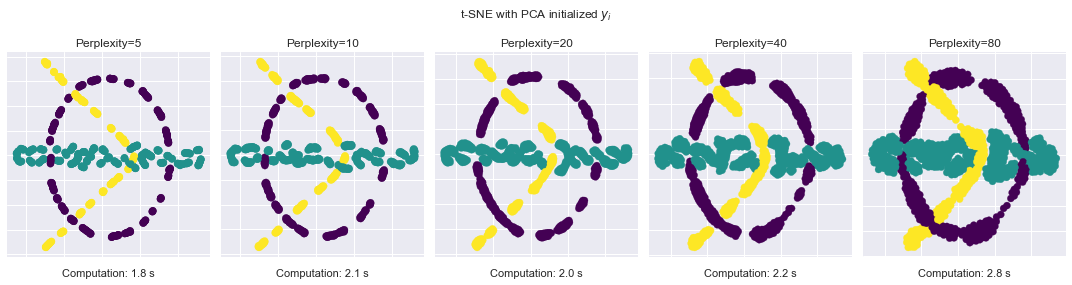

In [132]:
(fig, subplots) = plt.subplots(1,len(perplexities) , figsize=(3*len(perplexities), 4))
fig.suptitle("t-SNE with PCA initialized $y_i$")
X_all = [None]
for i, perplexity in enumerate(perplexities):
    ax = subplots[i]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='pca',
                         random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(x)
    t1 = time()
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=y,cmap='viridis')
    ax.tick_params(left=False,bottom=False)
    ax.set_xlabel("Computation: {:.2} s".format(t1-t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    X_all.append(Y)

fig.tight_layout()
plt.show()

The results obtained by t-SNE initialized with a PCA preserve the original structures much more closely than with randomly initialized vectors: the PCA removes the axis of least variance that basically aligns with the Z axis (the dataset spans along Z less than half the range of the other axis) and it just so happens that in this projection the prominent structures and patterns in the dataset were already well depicted and the t-SNE easily lands in a stable minimum. In fact, we can see that PCA already transforms data in a 2D distribution that is not far from the minimum that t-SNE eventually finds, proving that in some cases PCA dramatically reduces the stochasticity of the algorithm:

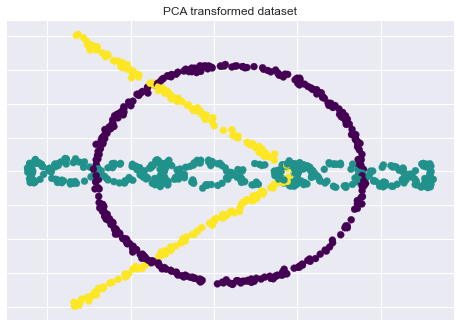

In [133]:
from sklearn.decomposition import PCA

pca = PCA(n_components=n_components)
x_pca = pca.fit_transform(x)

fig,ax = plt.subplots()
ax.set_title("PCA transformed dataset")
ax.scatter(x_pca[:,0],x_pca[:,1],c=y,cmap='viridis')
ax.tick_params(left=False,bottom=False)
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.show()

### 3) Tuning of “eps” and “minPts” in DBSCAN algorithm for clustering

The grid with several values of “eps” and “minPts” shows that the normalized mutual
information (NMI) between true and predicted clusters is varying. Is there a correlation
between these two parameters in providing a high NMI? Is there a way of guessing good
values for “eps” and “minPts”.
Note: in the lesson we have looked at the typical distance between a point and its closest
neighbor, but this does not say what is the typical distance from the 2nd, 3rd , …, “minPts”-
neighbor.
Furthermore, a possibility to consider is the <a href='http://sefidian.com/2020/12/18/how-to-determine-epsilon-and-minpts-parameters-of-dbscan-clustering/'>plotting of ranked distances.</a>

In [134]:
# functions to evaluate NMI

def clustering(y):
    # Finds position of labels and returns a dictionary of cluster labels to data indices.
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]
    return clustering

def entropy(c, n_sample):
    # Measures the entropy of a cluster
    h = 0.
    for kc in c.keys():
        p=len(c[kc])/n_sample
        h+=p*np.log(p)
    h*=-1.
    return h

# Normalized mutual information function
# Note that this deals with the label permutation problem
def NMI(y_true, y_pred):
    """ Computes normalized mutual information: where y_true and y_pred are both clustering assignments
    """
    w = clustering(y_true)
    c = clustering(y_pred)
    n_sample = len(y_true)

    Iwc = 0.
    for kw in w.keys():
        for kc in c.keys():
            w_intersect_c=len(set(w[kw]).intersection(set(c[kc])))
            if w_intersect_c > 0:
                Iwc += w_intersect_c*np.log(n_sample*w_intersect_c/(len(w[kw])*len(c[kc])))
    Iwc/=n_sample
    Hc = entropy(c,n_sample)
    Hw = entropy(w,n_sample)

    return 2*Iwc/(Hc+Hw)



In [135]:
# finding mean distance

def dist(x,i,j):
    return np.linalg.norm(x[i]-x[j])

print(dist(x,13,1))
mdist = np.zeros(N)
for i in range(N):
    dm = 1e100
    for j in range(N):
        if i!=j:
            dij = dist(x,i,j);
            if dij<dm:
                dm = dij
    mdist[i] = dm
mean_min_dist = mdist.mean()
print("mean minimum distance between points: ",mean_min_dist)

1552.6302096770091
mean minimum distance between points:  18.55757910124019


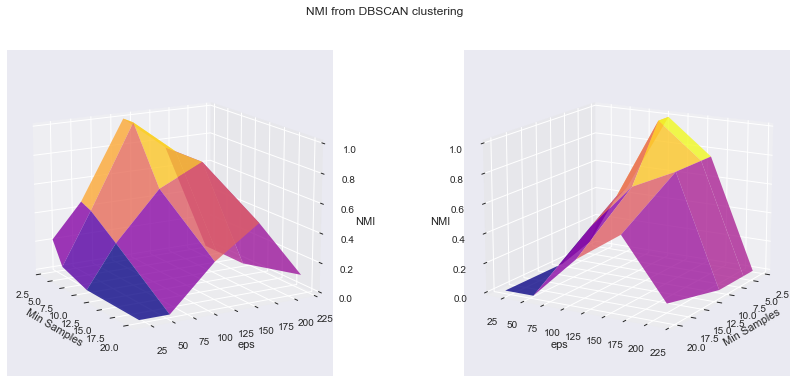

In [136]:
# DBSCAN has a few parameters, let's sweep over a few parameters and see what happens

n_true_center=3

X2D = X_all[1] # best visualization above, second plot of the PCA + tsne


y_true = y

#eps_range = [0.01,0.1,0.5,1.0,10.]
if mean_min_dist<10:
    r=mean_min_dist
else:
    r = int(mean_min_dist)

eps_range = [r,3*r,6*r,9*r,12*r]
min_sample_range = [3,5,10,20]

nmis = np.empty((len(eps_range),len(min_sample_range)))
for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(x)
        y_hat = model.labels_
        nmis[i,j]=NMI(y_hat, y_true)

rr,ee = np.meshgrid(min_sample_range,eps_range)

fig = plt.figure(figsize=[15,6])
fig.suptitle('NMI from DBSCAN clustering')
ax = fig.add_subplot(1,2,1,projection='3d')
ax.plot_surface(rr,ee,nmis,cmap='plasma',alpha=0.8)
ax.set_xlabel('Min Samples')
ax.set_ylabel('eps')
ax.set_zlabel('NMI')

ax2 = fig.add_subplot(1,2,2,projection='3d')
ax2.plot_surface(rr,ee,nmis,cmap='plasma',alpha=0.8)
ax2.set_xlabel('Min Samples')
ax2.set_ylabel('eps')
ax2.set_zlabel('NMI')

ax.view_init(15,-30)
ax2.view_init(15,30)
plt.show()


By plotting in a 3D space the NMI obtained by DBSCAN at different runs with different `eps` (ε) and `min_samples` ($MinPts$) parameters. The parameter ε is simply the radius of the circle to be created around each data point to check the density and $minPts$ is the minimum number of data points required inside that circle for that data point to be classified as a Core point. A good guess for the value of MinPts is usually 2 times the number of dimensions of the samples, but if the data is too large or too noisy, a higher value of MinPts should be chosen. 

Having set a particular value to $MinPts$, there's an associated optimal ε, that will generate the highest NMI possible. To find this optimal ε, we proceed as Sefidian [1]. We calculate the k-nearest distance of every point in the dataset and we plot them in an ascending order. The value of k is equal to $MinPts$.

The aim is to determine the “knee”, which corresponds to the optimal ε parameter. A knee corresponds to a threshold where a sharp change occurs along the k-distance curve.
Bellow we make 20 of these plots corresponding to values of k ($MinPts$) from 0 to 20.

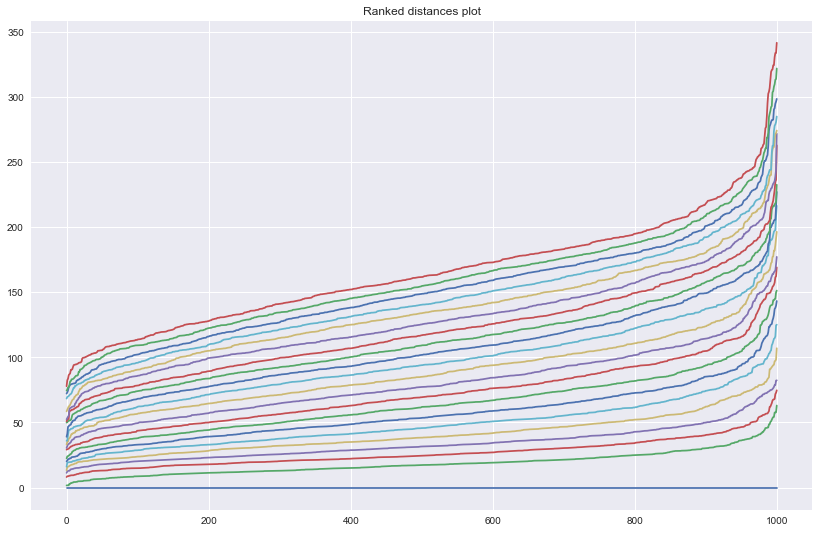

In [143]:
from sklearn.neighbors import NearestNeighbors
plt.style.use('seaborn')

k = 21  #we investigate till the 20th neighbor
nbrs = NearestNeighbors(n_neighbors=k)
nbrs.fit(x)
neigh_dist,neigh_ind=nbrs.kneighbors(x,return_distance=True)

distance=np.sort(neigh_dist,axis=0)
#distance=distance[:,1]

fig,ax=plt.subplots(figsize=(14,9))
ax.set_title("Ranked distances plot")
ax.plot(distance);



To find the threshold for the knee or elbow, the best approach we found was to use the &kneed$ python package. Given x and y arrays, kneed attempts to identify the knee/elbow point of a line fit to the data. The knee/elbow is defined as the point of the line with maximum curvature. 

optimal epsilon for minPts=3: 46.86696426762893
46.86696426762893


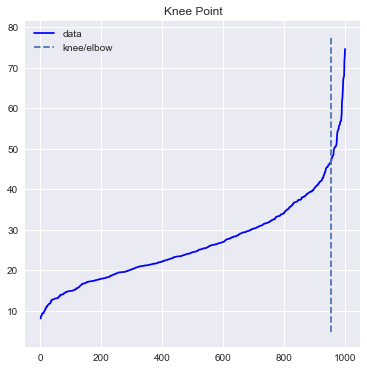

In [144]:
from kneed import KneeLocator

#let's try the knee package in order to find the maximum curvature'

n_points=np.arange(1,1001)
distance3=distance[:,2] #let's start with minPts=3

kl = KneeLocator(n_points, distance3, curve="convex")
kl.plot_knee()

print("optimal epsilon for minPts=3:",distance3[kl.knee])

print(distance[:,2][kl.knee])

We take a step further by plotting 17 "optimal" pairs of $MinPts$ and their correlated ε ($MinPts$ varrying from 3 to 20) and we see that the knee approach relates $MinPts$ and ε in an almost linear fashion. 

/Users/raffaelegaudio/miniforge3/lib/python3.9/site-packages/kneed/knee_locator.py:218: RuntimeWarning: invalid value encountered in true_divide
  return (a - min(a)) / (max(a) - min(a))
/Users/raffaelegaudio/miniforge3/lib/python3.9/site-packages/kneed/knee_locator.py:237: RuntimeWarning: No local maxima found in the difference curve
The line is probably not polynomial, try plotting
the difference curve with plt.plot(knee.x_difference, knee.y_difference)
Also check that you aren't mistakenly setting the curve argument
  warnings.warn(


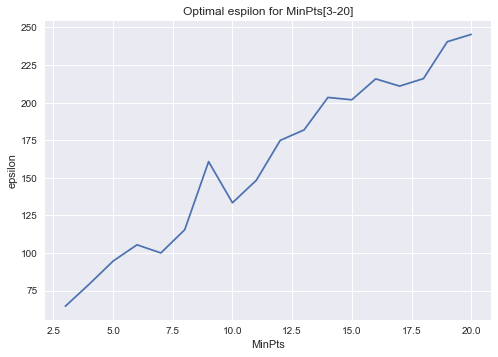

In [153]:
minPts=np.arange(3,21)
opt_esp=[]

for i in range(21):
    kl = KneeLocator(n_points, distance[:,i], curve="convex")
    opt_esp.append(distance[:,i][kl.knee])
    
  
plt.plot(minPts,opt_esp[3:])
plt.title("Optimal espilon for MinPts[3-20]")
plt.ylabel("epsilon") 
plt.xlabel("MinPts");

### Bibliography

[1] Sefidian, Amir Masaud - How to determine epsilon and MinPts parameters of DBSCAN clustering:
http://www.sefidian.com/2020/12/18/how-to-determine-epsilon-and-minpts-parameters-of-dbscan-clustering/